

**preprocessing includes:**

**1. replaced username with $<user>$ tag**

**2. replaced numbers with $<number>$ tag**

**3. removed RT-tags**

**4. Converted upper-case letters to lower-case**

**5. replaced many exclamation marks to one**

**6. replaced links with $<url>$ tag**

**7. replaced hashtags with $<emotion>$ tag**

**8. removed quotation mark**

**9. replaced the don't with (do not) and didn't with (did not)**

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils import data
import re
from termcolor import colored
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import torch.optim as optim
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, plot_confusion_matrix
from sklearn.model_selection import train_test_split

In [3]:
PreDataFrame = pd.read_csv('/content/drive/MyDrive/pre_main_data.csv')

In [4]:
sample_text = PreDataFrame['tweet'][0]
sample_text

'! <user> as a woman you should not complain about cleaning up your house and as a man you should always take the trash out'

In [5]:
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


**One of the major forms of pre-processing is to filter out useless data. In natural language processing, useless words (data), are referred to as stop words.**
**Stop Words: A stop word is a commonly used word (such as “the”, “a”, “an”, “in”) that a search engine has been programmed to ignore, both when indexing entries for searching and when retrieving them as the result of a search query.**

In [6]:
def remove_stop_words(text):
    stop_words = set(stopwords.words('english'))
    pstem = PorterStemmer()
    lem = WordNetLemmatizer()
    text_words = [ word for word in text.split() if (word not in stop_words or word in ['not', 'can'])]
    text = ' '.join(text_words)
    return text

In [7]:
print(colored('before removing the stopwords \n', 'red'), sample_text)
sample_text = remove_stop_words(sample_text)
print(colored('after removing the stopwords \n', 'red'), sample_text)

before removing the stopwords 
 ! <user> as a woman you should not complain about cleaning up your house and as a man you should always take the trash out
after removing the stopwords 
 ! <user> woman not complain cleaning house man always take trash


In [8]:
all_texts = PreDataFrame['tweet'].values
all_labels = PreDataFrame['label'].values
all_texts = [
             remove_stop_words(text)
             for text in tqdm(all_texts)
]

  0%|          | 0/24433 [00:00<?, ?it/s]

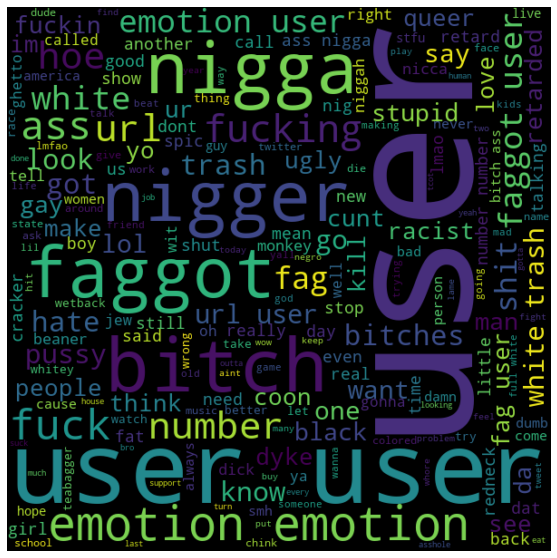

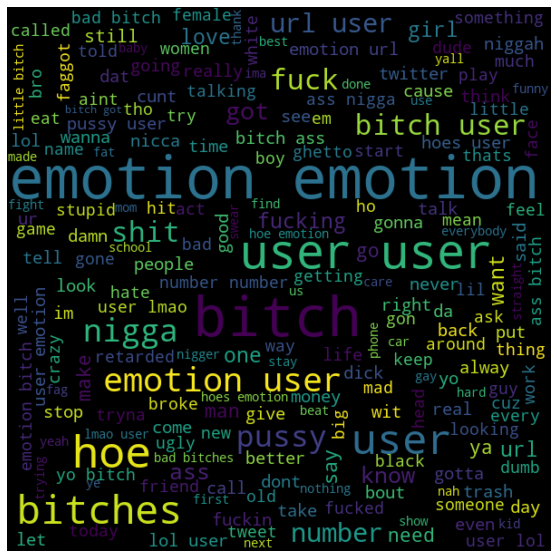

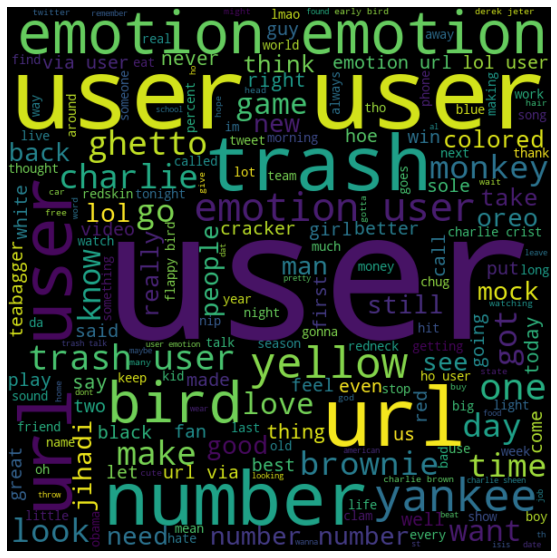

In [9]:
Hate_text = ''
Offensive_text = ''
Normal_text = ''
for i in range(len(all_labels)):
    if all_labels[i] == 0:
        Hate_text += all_texts[i]
    elif all_labels[i] == 1:
        Offensive_text += all_texts[i]   
    elif all_labels[i] == 2:
        Normal_text += all_texts[i]
from wordcloud import WordCloud
list_text = [Hate_text, Offensive_text, Normal_text]
for txt in list_text:
    word_cloud = WordCloud(width = 600,height = 600,max_font_size = 200).generate(txt)
    plt.figure(figsize=(12,10))# create a new figure
    plt.imshow(word_cloud,interpolation="bilinear")
    plt.axis("off")
    plt.show()

In [ ]:
!pip install transformers

In [12]:
from transformers import BertTokenizer, BertForSequenceClassification

# Load the BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

# Create a function to tokenize a set of texts
def preprocessing_for_bert(data):
    """Perform required preprocessing steps for pretrained BERT.
    @param    data (np.array): Array of texts to be processed.
    @return   input_ids (torch.Tensor): Tensor of token ids to be fed to a model.
    @return   attention_masks (torch.Tensor): Tensor of indices specifying which
                  tokens should be attended to by the model.
    """
    
    input_ids = []
    attention_masks = []

    # For every sentence...
    for sent in data:
        encoded_sent = tokenizer.encode_plus(
            text=sent,  # Preprocess sentence
            add_special_tokens=True,        # Add `[CLS]` and `[SEP]`
            max_length=MAX_LEN,                  # Max length to truncate/pad
            padding='max_length',
            truncation=True,
            return_attention_mask=True      # Return attention mask
            )
        
        # Add the outputs to the lists
        input_ids.append(encoded_sent.get('input_ids'))
        attention_masks.append(encoded_sent.get('attention_mask'))

    # Convert lists to tensors
    input_ids = torch.tensor(input_ids)
    attention_masks = torch.tensor(attention_masks)

    return input_ids, attention_masks

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [13]:
encoded_texts = [tokenizer.encode(sent, add_special_tokens=True) for sent in all_texts]

# Find the maximum length
max_len = max([len(sent) for sent in encoded_texts])
print('Max length: ', max_len)

Max length:  241


In [14]:
MAX_LEN = max_len

# Print sentence 0 and its encoded token ids
token_ids = list(preprocessing_for_bert([all_texts[0]])[0].squeeze().numpy())
print('Original: ', all_texts[0])
print('Token IDs: ', token_ids)

Original:  ! <user> woman not complain cleaning house man always take trash
Token IDs:  [101, 999, 1026, 5310, 1028, 2450, 2025, 17612, 9344, 2160, 2158, 2467, 2202, 11669, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


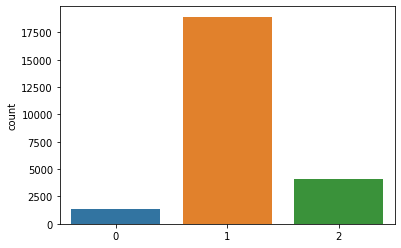

In [15]:
sns.countplot(all_labels)

In [16]:
X_train, X_test, y_train, y_test = train_test_split(all_texts, all_labels, test_size=0.2, random_state=42, stratify=all_labels)

In [17]:
from imblearn.over_sampling import RandomOverSampler
ros = RandomOverSampler(random_state=0)

X_train = np.array(X_train).reshape(-1, 1)

X_train, y_train = ros.fit_resample(X_train, y_train)

X_train = X_train.squeeze(1)

In [18]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=42, stratify=y_train)

In [19]:
print('the shape of the train split: {}'.format(len(X_train)))
print('the shape of the validation split: {}'.format(len(X_val)))
print('the shape of the test split: {}'.format(len(X_test)))

the shape of the train split: 40902
the shape of the validation split: 4545
the shape of the test split: 4887


In [20]:
print('Tokenizing data...')
train_inputs, train_masks = preprocessing_for_bert(X_train)
val_inputs, val_masks = preprocessing_for_bert(X_val)

Tokenizing data...


In [21]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

# Convert other data types to torch.Tensor
train_labels = torch.tensor(y_train)
val_labels = torch.tensor(y_val)

batch_size = 32

# Create the DataLoader for our training set
train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

# Create the DataLoader for our validation set
val_data = TensorDataset(val_inputs, val_masks, val_labels)
val_sampler = SequentialSampler(val_data)
val_dataloader = DataLoader(val_data, sampler=val_sampler, batch_size=batch_size)

In [22]:
%%time
import torch
import torch.nn as nn
from transformers import BertModel

# Create the BertClassfier class
class BertClassifier(nn.Module):
    """Bert Model for Classification Tasks.
    """
    def __init__(self, freeze_bert=False):
        """
        @param    bert: a BertModel object
        @param    classifier: a torch.nn.Module classifier
        @param    freeze_bert (bool): Set `False` to fine-tune the BERT model
        """
        super(BertClassifier, self).__init__()

        D_in, H, D_out = 768, 50, 3

        self.bert = BertModel.from_pretrained('bert-base-uncased')

        self.classifier = nn.Sequential(
            nn.Linear(D_in, H),
            nn.ReLU(),
            # nn.Dropout(0.5),
            nn.Linear(H, D_out)
        )

        # Freeze the BERT model
        if freeze_bert:
            for param in self.bert.parameters():
                param.requires_grad = False

    def forward(self, input_ids, attention_mask):
        """
        Feed input to BERT and the classifier to compute logits.
        @param    input_ids (torch.Tensor): an input tensor with shape (batch_size,
                      max_length)
        @param    attention_mask (torch.Tensor): a tensor that hold attention mask
                      information with shape (batch_size, max_length)
        @return   logits (torch.Tensor): an output tensor with shape (batch_size,
                      num_labels)
        """
        # Feed input to BERT
        outputs = self.bert(input_ids=input_ids,
                            attention_mask=attention_mask)
        

        # Extract the last hidden state of the token `[CLS]` for classification task
        last_hidden_state_cls = outputs[0][:, 0, :]

        # Feed input to classifier to compute logits
        logits = self.classifier(last_hidden_state_cls)

        return logits

CPU times: user 118 µs, sys: 4 µs, total: 122 µs
Wall time: 126 µs


In [23]:
import torch

if torch.cuda.is_available():       
    device = torch.device("cuda")
    print(f'There are {torch.cuda.device_count()} GPU(s) available.')
    print('Device name:', torch.cuda.get_device_name(0))

else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
Device name: Tesla T4


In [24]:
from transformers import AdamW, get_linear_schedule_with_warmup

def initialize_model(epochs=4):
    """Initialize the Bert Classifier, the optimizer and the learning rate scheduler.
    """
    # Instantiate Bert Classifier
    bert_classifier = BertClassifier(freeze_bert=False)

    # Tell PyTorch to run the model on GPU
    bert_classifier.to(device)

    # Create the optimizer
    optimizer = AdamW(bert_classifier.parameters(),
                      lr=5e-5,    # Default learning rate
                      eps=1e-8    # Default epsilon value
                      )

    # Total number of training steps
    total_steps = len(train_dataloader) * epochs

    # Set up the learning rate scheduler
    scheduler = get_linear_schedule_with_warmup(optimizer,
                                                num_warmup_steps=0, # Default value
                                                num_training_steps=total_steps)
    return bert_classifier, optimizer, scheduler

In [25]:
import random
import time

# Specify loss function
loss_fn = nn.CrossEntropyLoss()

def set_seed(seed_value=42):
    """Set seed for reproducibility.
    """
    random.seed(seed_value)
    np.random.seed(seed_value)
    torch.manual_seed(seed_value)
    torch.cuda.manual_seed_all(seed_value)

In [26]:
def train(model, train_dataloader, val_dataloader=None, epochs=4, evaluation=False):
    """Train the BertClassifier model.
    """

    val_accuracy_list = []
    train_accuracy_list = []
    val_loss_list = []
    train_loss_list = []

    # Start training loop
    print("Start training...\n")
    for epoch_i in range(epochs):

        train_epoch_accuracy_list = []
        train_epoch_loss_list = []
        
        print(f"{'Epoch':^7} | {'Batch':^7} | {'Train Loss':^12} | {'Val Loss':^10} | {'Val Acc':^9} | {'Elapsed':^9}")
        print("-"*70)

        # Measure the elapsed time of each epoch
        t0_epoch, t0_batch = time.time(), time.time()

        # Reset tracking variables at the beginning of each epoch
        total_loss, batch_loss, batch_counts = 0, 0, 0

        # Put the model into the training mode
        model.train()

        # For each batch of training data...
        for step, batch in enumerate(train_dataloader):
            batch_counts +=1

            b_input_ids, b_attn_mask, b_labels = tuple(t.to(device) for t in batch)

            model.zero_grad()


            logits = model(b_input_ids, b_attn_mask)

            loss = loss_fn(logits, b_labels)
            batch_loss += loss.item()
            total_loss += loss.item()

            preds = torch.argmax(logits, dim=1).flatten()

            accuracy = (preds == b_labels).cpu().numpy().mean() * 100
            train_epoch_accuracy_list.append(accuracy)
            train_epoch_loss_list.append(loss.item())


            # Perform a backward pass to calculate gradients
            loss.backward()

            # Clip the norm of the gradients to 1.0 to prevent "exploding gradients"
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

            # Update parameters and the learning rate
            optimizer.step()
            scheduler.step()

            # Print the loss values and time elapsed for every 20 batches
            if (step % 20 == 0 and step != 0) or (step == len(train_dataloader) - 1):
                # Calculate time elapsed for 20 batches
                time_elapsed = time.time() - t0_batch

                # Print training results
                print(f"{epoch_i + 1:^7} | {step:^7} | {batch_loss / batch_counts:^12.6f} | {'-':^10} | {'-':^9} | {time_elapsed:^9.2f}")

                # Reset batch tracking variables
                batch_loss, batch_counts = 0, 0
                t0_batch = time.time()

        # Calculate the average loss over the entire training data
        avg_train_loss = total_loss / len(train_dataloader)
        train_accuracy_list.append(np.mean(train_epoch_accuracy_list))
        train_loss_list.append(np.mean(train_epoch_loss_list))

        print("-"*70)

        if evaluation == True:
            # After the completion of each training epoch, measure the model's performance
            # on our validation set.
            val_loss, val_accuracy = evaluate(model, val_dataloader)
            val_accuracy_list.append(val_accuracy)
            val_loss_list.append(val_loss)

            # Print performance over the entire training data
            time_elapsed = time.time() - t0_epoch
            
            print(f"{epoch_i + 1:^7} | {'-':^7} | {avg_train_loss:^12.6f} | {val_loss:^10.6f} | {val_accuracy:^9.2f} | {time_elapsed:^9.2f}")
            print("-"*70)
        print("\n")
    
    print("Training complete!")
    return train_accuracy_list, train_loss_list, val_accuracy_list, val_loss_list

In [27]:
def evaluate(model, val_dataloader):
    """After the completion of each training epoch, measure the model's performance
    on our validation set.
    """
    # Put the model into the evaluation mode. The dropout layers are disabled during
    # the test time.
    model.eval()

    # Tracking variables
    val_accuracy = []
    val_loss = []

    # For each batch in our validation set...
    for batch in val_dataloader:
        # Load batch to GPU
        b_input_ids, b_attn_mask, b_labels = tuple(t.to(device) for t in batch)

        # Compute logits
        with torch.no_grad():
            logits = model(b_input_ids, b_attn_mask)

        # Compute loss
        loss = loss_fn(logits, b_labels)
        val_loss.append(loss.item())

        # Get the predictions
        preds = torch.argmax(logits, dim=1).flatten()

        # Calculate the accuracy rate
        accuracy = (preds == b_labels).cpu().numpy().mean() * 100
        val_accuracy.append(accuracy)

    # Compute the average accuracy and loss over the validation set.
    val_loss = np.mean(val_loss)
    val_accuracy = np.mean(val_accuracy)

    return val_loss, val_accuracy

In [28]:
set_seed(42)
bert_classifier, optimizer, scheduler = initialize_model(epochs=3)
train_accuracy_list, train_loss_list, val_accuracy_list, val_loss_list = train(bert_classifier, train_dataloader, val_dataloader, epochs=5, evaluation=True)

Downloading:   0%|          | 0.00/420M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a

Start training...

 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
----------------------------------------------------------------------
   1    |   20    |   0.996747   |     -      |     -     |   23.96  
   1    |   40    |   0.646411   |     -      |     -     |   23.20  
   1    |   60    |   0.555916   |     -      |     -     |   23.45  
   1    |   80    |   0.515594   |     -      |     -     |   23.79  
   1    |   100   |   0.478272   |     -      |     -     |   24.16  
   1    |   120   |   0.424866   |     -      |     -     |   24.63  
   1    |   140   |   0.447459   |     -      |     -     |   24.87  
   1    |   160   |   0.452878   |     -      |     -     |   25.22  
   1    |   180   |   0.439995   |     -      |     -     |   25.24  
   1    |   200   |   0.417585   |     -      |     -     |   25.40  
   1    |   220   |   0.423836   |     -      |     -     |   25.74  
   1    |   240   |   0.415922   |     -      |     -     |   25.81  


In [29]:
def plot_train_test_metric(train_acc, val_acc, xlabel, ylabel, title, metric):
    fig = plt.figure(figsize=(10, 6))
    plt.plot(train_acc, color='salmon', label='train {}'.format(metric), marker='o', linewidth=1)
    plt.annotate(str(np.round(train_acc[-1], 1)) + '%', (len(train_acc) - .8, train_acc[-1]), color='salmon')
    plt.plot(val_acc, color='skyblue', label='test {}'.format(metric), marker='o', linewidth=1)
    plt.annotate(str(np.round(val_acc[-1], 1)) + '%', (len(val_acc) - .8, val_acc[-1]), color='skyblue')
    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)
    plt.legend()
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.grid(axis='y')

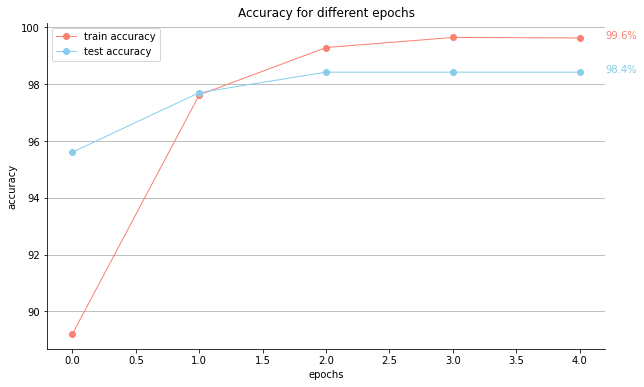

In [30]:
plot_train_test_metric(train_accuracy_list, val_accuracy_list, "epochs", "accuracy", "Accuracy for different epochs", "accuracy")

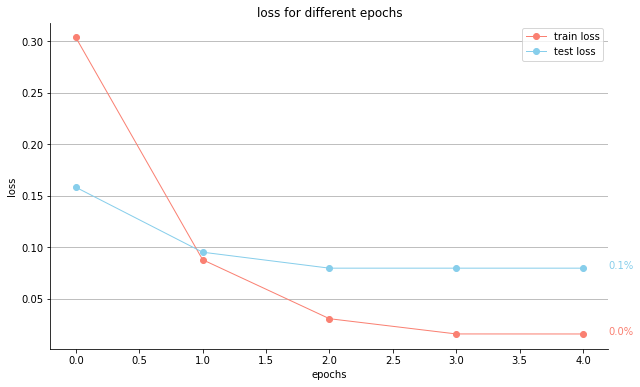

In [31]:
plot_train_test_metric(train_loss_list, val_loss_list, "epochs", "loss", "loss for different epochs", "loss")

In [32]:
print('Tokenizing data...')
test_inputs, test_masks = preprocessing_for_bert(X_test)

# Create the DataLoader for our test set
test_dataset = TensorDataset(test_inputs, test_masks)
test_sampler = SequentialSampler(test_dataset)
test_dataloader = DataLoader(test_dataset, sampler=test_sampler, batch_size=32)

Tokenizing data...


In [33]:
import torch.nn.functional as F

def bert_predict(model, test_dataloader):
    """Perform a forward pass on the trained BERT model to predict probabilities
    on the test set.
    """
    # Put the model into the evaluation mode. The dropout layers are disabled during
    # the test time.
    model.eval()

    all_logits = []

    # For each batch in our test set...
    for batch in test_dataloader:
        # Load batch to GPU
        b_input_ids, b_attn_mask = tuple(t.to(device) for t in batch)[:2]

        # Compute logits
        with torch.no_grad():
            logits = model(b_input_ids, b_attn_mask)
        all_logits.append(logits)
    
    # Concatenate logits from each batch
    all_logits = torch.cat(all_logits, dim=0)

    # Apply softmax to calculate probabilities
    probs = F.softmax(all_logits, dim=1).cpu().numpy()

    return probs

In [34]:
probs = bert_predict(bert_classifier, test_dataloader)

In [35]:
classes = []
for i in range(len(probs)):
  if np.argmax(probs[i]) == 0 :
    classes.append(0)
  elif np.argmax(probs[i]) == 1:
    classes.append(1)
  else:
    classes.append(2)

Text(0.5, 1.0, 'confusion matrix representing the performance of the model')

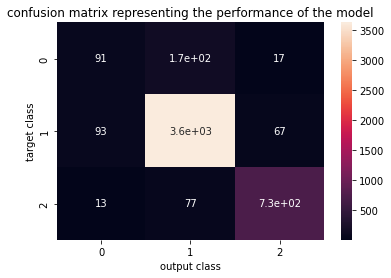

In [36]:
sns.heatmap(confusion_matrix(y_test, classes), annot=True)
plt.ylabel('target class')
plt.xlabel('output class')
plt.title('confusion matrix representing the performance of the model')

In [39]:
acc = accuracy_score(y_test, classes)*100
acc

91.03744628606508

In [40]:
if acc > 91:
  print('Excellent job, You get the bonous!')

Excellent job, You get the bonous!
